imports

In [1]:
import tensorflow as tf
import keras_nlp

import random

import matplotlib.pyplot as plt

import pickle

2025-10-09 09:54:07.106123: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759983847.122374   22617 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759983847.127246   22617 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1759983847.139767   22617 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759983847.139791   22617 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759983847.139794   22617 computation_placer.cc:177] computation placer alr

hyperparameters

In [2]:
SHUFFLE_BUFFER_SIZE = 10000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE
BATCH_SIZE = 128

working on the actual dataset

In [3]:
with open('data/negative-words.txt', 'r', encoding='latin-1') as f:
    neg_words = [line.strip() for line in f if line.strip()]
    
with open('data/positive-words.txt', 'r', encoding='latin-1') as f:
    pos_words = [line.strip() for line in f if line.strip()]

# 0 SIGNALS NEGATIVE WHEREAS 1 SIGNALS POSITIVE

words = neg_words + pos_words
labels = [0] * len(neg_words) + [1] * len(pos_words)

combined = list(zip(words, labels))
random.seed(42)
random.shuffle(combined)

words, labels = zip(*combined)
words = list(words)
labels = list(labels)

total = len(words)
train_end = int(0.8 * total)

train_words = words[:train_end]
train_labels = labels[:train_end]

test_words = words[train_end:]
test_labels = labels[train_end:]

print(f"Train: {len(train_words)}")
print(f"Test: {len(test_words)}")

Train: 5431
Test: 1358


In [4]:
word_dataset = tf.data.Dataset.from_tensor_slices(words)

I0000 00:00:1759983855.116069   22617 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5196 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [5]:
vocab = keras_nlp.tokenizers.compute_word_piece_vocabulary(
    word_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE),
    vocabulary_size=5000, 
    lowercase=True,
    reserved_tokens=["[PAD]", "[UNK]", "[START]", "[END]"]
)

2025-10-09 09:54:17.072249: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [6]:
VOCAB_SIZE = len(vocab)
print(f"Vocabulary size: {VOCAB_SIZE}")

Vocabulary size: 309


In [7]:
tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary=vocab,
    lowercase=True,
    sequence_length=16
)

In [8]:
train_words_ds = tf.data.Dataset.from_tensor_slices(train_words)
train_labels_ds = tf.data.Dataset.from_tensor_slices(train_labels)

test_words_ds = tf.data.Dataset.from_tensor_slices(test_words)
test_labels_ds = tf.data.Dataset.from_tensor_slices(test_labels)

data pipeline

In [9]:
train_sequences_subword = train_words_ds.map(
    lambda word: tokenizer(word),
    num_parallel_calls=tf.data.AUTOTUNE
)

test_sequences_subword = test_words_ds.map(
    lambda word: tokenizer(word),
    num_parallel_calls=tf.data.AUTOTUNE
)

In [10]:
train_dataset_vectorized = tf.data.Dataset.zip((train_sequences_subword, train_labels_ds))
test_dataset_vectorized = tf.data.Dataset.zip((test_sequences_subword, test_labels_ds))


train_dataset_final = (train_dataset_vectorized
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .cache()
                       .batch(BATCH_SIZE)
                       .prefetch(buffer_size=PREFETCH_BUFFER_SIZE)
                       )

test_dataset_final = (test_dataset_vectorized
                      .cache()
                      .batch(BATCH_SIZE)
                      .prefetch(buffer_size=PREFETCH_BUFFER_SIZE)
                      )

sanity check

In [11]:
for example in train_dataset_final.take(2):
  print(example)
  print()

(<tf.Tensor: shape=(128, 16), dtype=int32, numpy=
array([[ 27,  50, 134, ...,   0,   0,   0],
       [  9, 304, 160, ...,   0,   0,   0],
       [ 12, 306, 300, ...,   0,   0,   0],
       ...,
       [  8,  39,  70, ...,   0,   0,   0],
       [ 10, 123, 153, ...,   0,   0,   0],
       [ 26, 134, 212, ...,   0,   0,   0]], dtype=int32)>, <tf.Tensor: shape=(128,), dtype=int32, numpy=
array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1], dtype=int32)>)

(<tf.Tensor: shape=(128, 16), dtype=int32, numpy=
array([[ 11, 301,  35, ...,   0,   0,   0],
       [ 13,  74, 108, ...,   0,   0,   0],
       [  8, 165,  95, ...,   0

2025-10-09 09:54:35.248168: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-10-09 09:54:35.249272: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


a function to plot accuracy and the loss function against epochs

In [12]:
def plot_loss_acc(history):

    train_acc = history.history['accuracy']        
    test_acc = history.history['val_accuracy']     
    train_loss = history.history['loss']           
    test_loss = history.history['val_loss']        

    epochs = range(len(train_acc))

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    ax[0].plot(epochs, train_acc, 'bo', label='Training accuracy')
    ax[0].plot(epochs, test_acc, 'b', label='Validation accuracy')
    ax[0].set_title('Training and Validation accuracy')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()

    ax[1].plot(epochs, train_loss, 'bo', label='Training Loss')
    ax[1].plot(epochs, test_loss, 'b', label='Validation Loss')
    ax[1].set_title('Training and Validation loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

    plt.tight_layout()
    plt.show()


using single LSTMs

In [13]:
EMBEDDING_DIM = 16
LSTM_DIM = 32
DENSE_DIM = 6
MAX_LENGTH = 16

model_lstm = tf.keras.Sequential([
    tf.keras.Input(shape=(MAX_LENGTH,)),
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM_DIM)),
    tf.keras.layers.Dense(DENSE_DIM, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 16, 16)         │         4,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │        12,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │           390 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,885 (69.86 KB)

 Trainable params: 17,885 (69.86 KB)

 Non-trainable params: 0 (0.00 B)

early callback function

In [14]:
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs['val_loss']<0.55:
            self.model.stop_training = True
            print("\nReached a decent enough (still bad) guess from the model thus far.")

actual model training

In [15]:
NUM_EPOCHS = 45

history_lstm = model_lstm.fit(train_dataset_final, epochs=NUM_EPOCHS, validation_data=test_dataset_final, verbose=2, callbacks = [EarlyStoppingCallback()])

Epoch 1/45


I0000 00:00:1759983888.595319   22692 cuda_dnn.cc:529] Loaded cuDNN version 91301


43/43 - 3s - 72ms/step - accuracy: 0.6955 - loss: 0.6270 - val_accuracy: 0.7077 - val_loss: 0.6021
Epoch 2/45
43/43 - 0s - 6ms/step - accuracy: 0.7037 - loss: 0.6009 - val_accuracy: 0.7077 - val_loss: 0.5858
Epoch 3/45
43/43 - 0s - 6ms/step - accuracy: 0.7078 - loss: 0.5708 - val_accuracy: 0.7342 - val_loss: 0.5507
Epoch 4/45

Reached a decent enough (still bad) guess from the model thus far.
43/43 - 0s - 6ms/step - accuracy: 0.7363 - loss: 0.5383 - val_accuracy: 0.7275 - val_loss: 0.5413


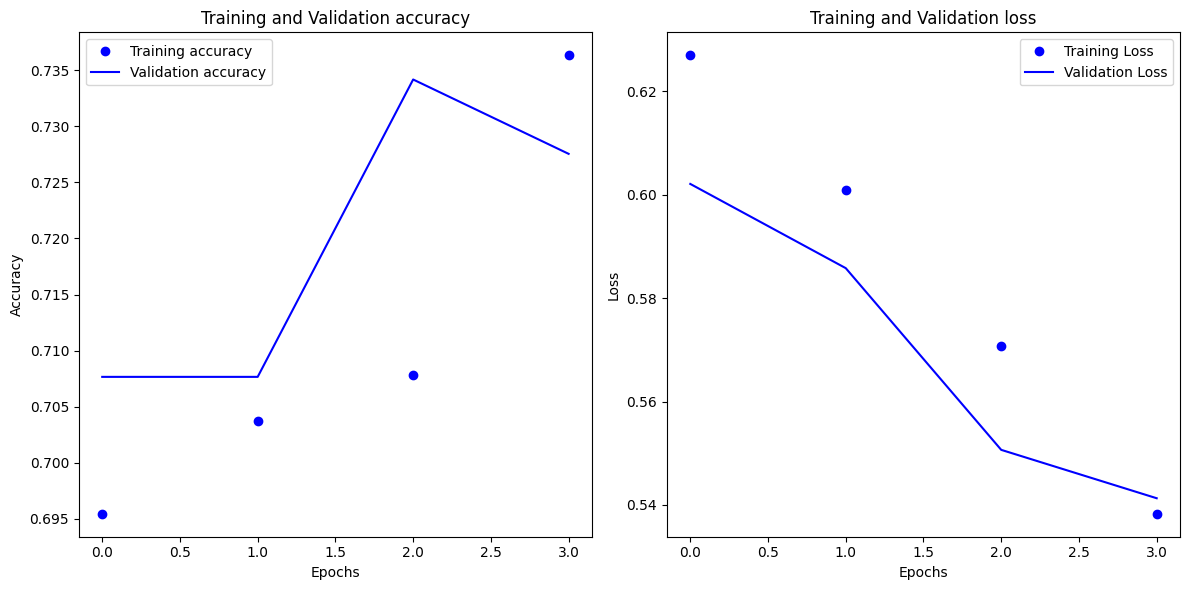

In [16]:
plot_loss_acc(history_lstm)

In [17]:
with open('model.pkl','wb') as f:
    pickle.dump(history_lstm.history , f)

the final model is moved to /models dir